In [1]:
import pandas as pd
import shapely
import numpy as np
import sys
import torch
import argparse
import random
import math
import os
import warnings
from datetime import datetime
from gensim.models import word2vec
from shapely.geometry import LineString, Polygon
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler# 好处在于可以保存训练集中的参数（均值、方差）
from scipy.stats import stats
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
pd.options.display.max_columns = 999
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
import gc
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%run '../codes/self_defined_function.py'

## preprocessing and feature selection
take ArtNr '200032' as example

In [3]:
# load data
df = pd.read_csv('../data/Artikelbewegungen ab 1996.txt', sep=';', encoding = 'ISO-8859-1', header=None)
#df = pd.read_excel('../data/Artikelbewegungen.xlsx')

In [4]:
df = preprocessing(df)

In [5]:
# continue with preprocessing 

In [17]:
tmp.describe()

,Menge,weekday
count,3715.000,3715.000
mean,1192.520,2.000
std,918.446,1.414
min,0.000,0.000
25%,480.000,1.000
50%,1060.000,2.000
75%,1740.000,3.000
max,4000.000,4.000


(array([1.925e+03, 7.400e+01, 9.300e+01, 1.250e+02, 1.350e+02, 1.330e+02,
        1.600e+02, 1.180e+02, 1.180e+02, 1.760e+02, 8.900e+01, 1.390e+02,
        1.820e+02, 1.210e+02, 1.210e+02, 1.330e+02, 1.120e+02, 9.000e+01,
        1.200e+02, 1.050e+02, 9.800e+01, 8.600e+01, 5.900e+01, 5.900e+01,
        8.400e+01, 5.100e+01, 4.700e+01, 4.900e+01, 4.600e+01, 4.400e+01,
        3.900e+01, 3.000e+01, 3.200e+01, 2.100e+01, 2.400e+01, 1.400e+01,
        2.100e+01, 1.700e+01, 1.200e+01, 1.100e+01, 6.000e+00, 1.500e+01,
        8.000e+00, 7.000e+00, 5.000e+00, 8.000e+00, 6.000e+00, 7.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 1.000e+00, 2.000e+00,
        6.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

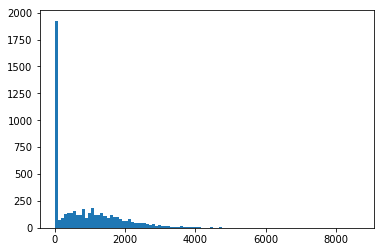

In [30]:
#plt.hist(tmp[tmp['Menge'] != 0].values, bins=100)
plt.hist(tmp.values, bins = 100)

In [29]:
# grid table create
tmp = create_grid_data_for_an_article('200032', df)

In [21]:
# set the top threshold
tmp['Menge'] = tmp['Menge'].map(lambda x: x if x < 4000 else 4000)

In [36]:
# how to deal with 0 value
tmp1 = tmp[tmp['Menge'] == 0]

In [37]:
# most 0 value happens in friday and monday
tmp1['weekday'].value_counts()

4    151
0     90
3     67
2     46
1     39
Name: weekday, dtype: int64

In [32]:
# feature selection, only weekday
tmp['weekday'] = tmp.index.weekday

In [33]:
# remove weekend
tmp = tmp[tmp['weekday'] != 5]
tmp = tmp[tmp['weekday'] != 6]

In [11]:
def extract_dataset_from_timeseries(df, targetname = 'Menge', lookback = 5):
    """
    df should not contain the features, which will not used in the traning of the model
    """
    for i in range(lookback):
        df[targetname+'_'+str(i+1)] = df[targetname].shift(i+1)
    cols = df.columns.to_list()
    cols_x = [i for i in cols if i not in [targetname]]
    cols_y = [targetname]
    dat_x = df[cols_x].iloc[lookback:, :].values
    dat_y = df[cols_y].iloc[lookback:, :].values
    return dat_x, dat_y
def extract_dataset_from_timeseries_with_diff(df, targetname = 'Menge', lookback = 5):
    """
    df should not contain the features, which will not used in the traning of the model
    """
    for i in range(lookback):
        df[targetname+'_'+str(i+1)] = df[targetname].shift(i+1)
    if lookback >=5:
        df['diff_1'] = df[targetname+'_'+str(1)] - df[targetname+'_'+str(2)]
        df['diff_2'] = df[targetname+'_'+str(3)] - df[targetname+'_'+str(4)]
        df['diff2_1'] = df['diff_1'] - df['diff_2']
    cols = df.columns.to_list()
    cols_x = [i for i in cols if i not in [targetname]]
    cols_y = [targetname]
    dat_x = df[cols_x].iloc[lookback:, :].values
    dat_y = df[cols_y].iloc[lookback:, :].values
    return dat_x, dat_y

In [60]:
# extract dataset for mlp
dat_x, dat_y = extract_dataset_from_timeseries_with_diff(tmp, lookback = 20)

In [12]:
train_x = dat_x[:2589, :]
test_x = dat_x[2589:, :]
train_y = dat_y[:2589, :].reshape(-1)
test_y = dat_y[2589:, :].reshape(-1)

In [13]:
# save to the local system
np.save('../data/rnn_train_x', train_x)
np.save('../data/rnn_train_y', train_y)
np.save('../data/rnn_test_x', test_x)
np.save('../data/rnn_test_y', test_y)

In [12]:
# extract dataset for lstm
dat_x, dat_y = extract_dataset_from_timeseries(tmp[['Menge']], lookback = 20)

In [13]:
dat_x.shape

(3695, 20)

In [14]:
train_x = dat_x[:2589, :].reshape(-1, 20, 1)
test_x = dat_x[2589:, :].reshape(-1, 20, 1)
train_y = dat_y[:2589, :].reshape(-1)
test_y = dat_y[2589:, :].reshape(-1)

In [15]:
np.save('../data/rnn_train_x', train_x)
np.save('../data/rnn_train_y', train_y)
np.save('../data/rnn_test_x', test_x)
np.save('../data/rnn_test_y', test_y)

In [115]:
### test data
train_y = train_x[:,1] * 10 + 2 - 3
test_y = test_x[:, 1] * 10 + 2 - 3
np.save('../data/rnn_train_x', train_x)
np.save('../data/rnn_train_y', train_y)
np.save('../data/rnn_test_x', test_x)
np.save('../data/rnn_test_y', test_y)

In [160]:
train_x.shape

(2589, 4, 1)

## train with mlp model

In [16]:
# run the model
tr_x = '../data/rnn_train_x.npy'
tr_y = '../data/rnn_train_y.npy'
tet_x = '../data/rnn_test_x.npy'
tet_y = '../data/rnn_test_y.npy'
num_epochs = 2000
batch_size = 30
verbose = True
# set models and loss
model = TS_rnn(num_inp = 1, num_hidden = 32, num_layers = 2, dropout = 0, num_dim_mlp = 16) # (self, num_inp = 13, num_hidden = 64, num_layers = 2, dropout = 0.5, num_dim_mlp = 16)
#model = MLP_dropout(num_inp = 24, num_hidden = 256, num_hidden2 = 64) # (self, num_inp = 1, num_hidden = 64, num_hidden2 = 16)
#model = TS_rnn()
#loss = PDLoss()
loss = torch.nn.L1Loss()
#loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
# set the scheduler
lamb1 = lambda x: .1**(x//30)
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda = lamb1)
# loda data
train = Data(tr_x, tr_y)
test = Data(tet_x, tet_y)
dl_train = DataLoader(train, batch_size = batch_size, shuffle = True)
dl_test = DataLoader(test, batch_size = batch_size, shuffle = True)
#train the model
for epoch in range(num_epochs):
    #scheduler.step()
    model.train()
    train_loss = 0
    counter = 0
    for batch_idx, dat in enumerate(dl_train):
        counter += 1
        # train the model
        optimizer.zero_grad()
        inp, target = dat
        #print('----------------')
        out = model(inp)
        #print(out.squeeze())
        #print(target)
        lo = loss(out.squeeze(), target)
        lo.backward()
        optimizer.step()
        train_loss += lo.data
        if verbose:
            if batch_idx % 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch,
                    batch_idx * batch_size,
                    len(train),
                    100.*batch_idx*batch_size/len(train),
                    lo.data
                    ))
    test_lo = test_model(dl_test, model, loss)
    #hit_rate = significant_test(dl_test, model, loss)
    if verbose:
        # train loss
        print('====> Epoch: {} Average train loss: {:.4f}'.format(
            epoch,
            train_loss/counter
            ))
        # test loss
        print('====> Epoch: {} Average test loss: {:.4f}'.format(
            epoch,
            test_lo
            ))
        # significant test
        #print('====> Epoch: {} Average hit rate in 10 candidate: {: .4f}'.format(
        #    epoch,
        #    hit_rate
        #))

TS_rnn(
  (rnn): LSTM(1, 32, num_layers=2)
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): Dropout(p=0.5)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
)

Train Epoch: 0 [0/2589 (0%)]	Loss: 1213.930542
Train Epoch: 0 [300/2589 (12%)]	Loss: 979.437317
Train Epoch: 0 [600/2589 (23%)]	Loss: 1360.304077
Train Epoch: 0 [900/2589 (35%)]	Loss: 956.174805
Train Epoch: 0 [1200/2589 (46%)]	Loss: 1059.621338
Train Epoch: 0 [1500/2589 (58%)]	Loss: 1166.532104
Train Epoch: 0 [1800/2589 (70%)]	Loss: 1019.242249
Train Epoch: 0 [2100/2589 (81%)]	Loss: 1054.201660
Train Epoch: 0 [2400/2589 (93%)]	Loss: 1326.783447
====> Epoch: 0 Average train loss: 1091.8757
====> Epoch: 0 Average test loss: 1146.6466


TS_rnn(
  (rnn): LSTM(1, 32, num_layers=2)
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): Dropout(p=0.5)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
)

Train Epoch: 1 [0/2589 (0%)]	Loss: 1057.894409
Train Epoch: 1 [300/2589 (12%)]	Loss: 867.055725
Train Epoch: 1 [600/2589 (23%)]	Loss: 1134.792358
Train Epoch: 1 [900/2589 (35%)]	Loss: 1027.961670
Train Epoch: 1 [1200/2589 (46%)]	Loss: 1177.401978
Train Epoch: 1 [1500/2589 (58%)]	Loss: 946.346741
Train Epoch: 1 [1800/2589 (70%)]	Loss: 631.236267
Train Epoch: 1 [2100/2589 (81%)]	Loss: 655.593079
Train Epoch: 1 [2400/2589 (93%)]	Loss: 966.473389
====> Epoch: 1 Average train loss: 844.2971
====> Epoch: 1 Average test loss: 865.6987


TS_rnn(
  (rnn): LSTM(1, 32, num_layers=2)
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): Dropout(p=0.5)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
)

Train Epoch: 2 [0/2589 (0%)]	Loss: 751.483948
Train Epoch: 2 [300/2589 (12%)]	Loss: 745.699768
Train Epoch: 2 [600/2589 (23%)]	Loss: 718.931396
Train Epoch: 2 [900/2589 (35%)]	Loss: 845.124573
Train Epoch: 2 [1200/2589 (46%)]	Loss: 804.793091
Train Epoch: 2 [1500/2589 (58%)]	Loss: 709.468201
Train Epoch: 2 [1800/2589 (70%)]	Loss: 541.533386
Train Epoch: 2 [2100/2589 (81%)]	Loss: 688.235962
Train Epoch: 2 [2400/2589 (93%)]	Loss: 718.265625
====> Epoch: 2 Average train loss: 754.9598
====> Epoch: 2 Average test loss: 838.4396


TS_rnn(
  (rnn): LSTM(1, 32, num_layers=2)
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): Dropout(p=0.5)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
)

Train Epoch: 3 [0/2589 (0%)]	Loss: 954.245728
Train Epoch: 3 [300/2589 (12%)]	Loss: 797.751343
Train Epoch: 3 [600/2589 (23%)]	Loss: 771.305359
Train Epoch: 3 [900/2589 (35%)]	Loss: 548.688232
Train Epoch: 3 [1200/2589 (46%)]	Loss: 888.230896
Train Epoch: 3 [1500/2589 (58%)]	Loss: 601.101929
Train Epoch: 3 [1800/2589 (70%)]	Loss: 746.789978
Train Epoch: 3 [2100/2589 (81%)]	Loss: 765.699402
Train Epoch: 3 [2400/2589 (93%)]	Loss: 795.913208
====> Epoch: 3 Average train loss: 750.4266
====> Epoch: 3 Average test loss: 833.7969


TS_rnn(
  (rnn): LSTM(1, 32, num_layers=2)
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): Dropout(p=0.5)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
)

Train Epoch: 4 [0/2589 (0%)]	Loss: 883.401550
Train Epoch: 4 [300/2589 (12%)]	Loss: 856.630798
Train Epoch: 4 [600/2589 (23%)]	Loss: 810.696411
Train Epoch: 4 [900/2589 (35%)]	Loss: 766.316467
Train Epoch: 4 [1200/2589 (46%)]	Loss: 639.830261
Train Epoch: 4 [1500/2589 (58%)]	Loss: 757.001587
Train Epoch: 4 [1800/2589 (70%)]	Loss: 596.687256
Train Epoch: 4 [2100/2589 (81%)]	Loss: 869.160767
Train Epoch: 4 [2400/2589 (93%)]	Loss: 760.244507
====> Epoch: 4 Average train loss: 751.9179
====> Epoch: 4 Average test loss: 832.0529


TS_rnn(
  (rnn): LSTM(1, 32, num_layers=2)
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): Dropout(p=0.5)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
)

Train Epoch: 5 [0/2589 (0%)]	Loss: 819.407288
Train Epoch: 5 [300/2589 (12%)]	Loss: 675.884644
Train Epoch: 5 [600/2589 (23%)]	Loss: 635.250061
Train Epoch: 5 [900/2589 (35%)]	Loss: 816.765991
Train Epoch: 5 [1200/2589 (46%)]	Loss: 667.954468
Train Epoch: 5 [1500/2589 (58%)]	Loss: 877.106689
Train Epoch: 5 [1800/2589 (70%)]	Loss: 772.575806
Train Epoch: 5 [2100/2589 (81%)]	Loss: 685.782288
Train Epoch: 5 [2400/2589 (93%)]	Loss: 787.690552
====> Epoch: 5 Average train loss: 766.7702
====> Epoch: 5 Average test loss: 840.2310


TS_rnn(
  (rnn): LSTM(1, 32, num_layers=2)
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): Dropout(p=0.5)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
)

Train Epoch: 6 [0/2589 (0%)]	Loss: 755.150330
Train Epoch: 6 [300/2589 (12%)]	Loss: 793.222839
Train Epoch: 6 [600/2589 (23%)]	Loss: 842.314880
Train Epoch: 6 [900/2589 (35%)]	Loss: 618.432373
Train Epoch: 6 [1200/2589 (46%)]	Loss: 978.135864
Train Epoch: 6 [1500/2589 (58%)]	Loss: 691.671326
Train Epoch: 6 [1800/2589 (70%)]	Loss: 784.105469
Train Epoch: 6 [2100/2589 (81%)]	Loss: 810.665405
Train Epoch: 6 [2400/2589 (93%)]	Loss: 774.926392
====> Epoch: 6 Average train loss: 761.1086
====> Epoch: 6 Average test loss: 839.4348


TS_rnn(
  (rnn): LSTM(1, 32, num_layers=2)
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): Dropout(p=0.5)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
)

Train Epoch: 7 [0/2589 (0%)]	Loss: 788.692017
Train Epoch: 7 [300/2589 (12%)]	Loss: 908.909119
Train Epoch: 7 [600/2589 (23%)]	Loss: 884.097900
Train Epoch: 7 [900/2589 (35%)]	Loss: 727.809570
Train Epoch: 7 [1200/2589 (46%)]	Loss: 872.305420
Train Epoch: 7 [1500/2589 (58%)]	Loss: 739.407532
Train Epoch: 7 [1800/2589 (70%)]	Loss: 936.546021
Train Epoch: 7 [2100/2589 (81%)]	Loss: 849.156311
Train Epoch: 7 [2400/2589 (93%)]	Loss: 726.782104
====> Epoch: 7 Average train loss: 771.6732
====> Epoch: 7 Average test loss: 836.2278


TS_rnn(
  (rnn): LSTM(1, 32, num_layers=2)
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): Dropout(p=0.5)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
)

Train Epoch: 8 [0/2589 (0%)]	Loss: 820.538269
Train Epoch: 8 [300/2589 (12%)]	Loss: 758.340454
Train Epoch: 8 [600/2589 (23%)]	Loss: 731.010437
Train Epoch: 8 [900/2589 (35%)]	Loss: 857.628662
Train Epoch: 8 [1200/2589 (46%)]	Loss: 650.703369
Train Epoch: 8 [1500/2589 (58%)]	Loss: 598.777527
Train Epoch: 8 [1800/2589 (70%)]	Loss: 835.038635
Train Epoch: 8 [2100/2589 (81%)]	Loss: 705.046875
Train Epoch: 8 [2400/2589 (93%)]	Loss: 673.304749
====> Epoch: 8 Average train loss: 765.0901
====> Epoch: 8 Average test loss: 833.0532


TS_rnn(
  (rnn): LSTM(1, 32, num_layers=2)
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): Dropout(p=0.5)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
)

Train Epoch: 9 [0/2589 (0%)]	Loss: 675.480591
Train Epoch: 9 [300/2589 (12%)]	Loss: 864.487610
Train Epoch: 9 [600/2589 (23%)]	Loss: 795.615540
Train Epoch: 9 [900/2589 (35%)]	Loss: 741.410034
Train Epoch: 9 [1200/2589 (46%)]	Loss: 873.771240
Train Epoch: 9 [1500/2589 (58%)]	Loss: 862.873901
Train Epoch: 9 [1800/2589 (70%)]	Loss: 767.767395
Train Epoch: 9 [2100/2589 (81%)]	Loss: 860.707275
Train Epoch: 9 [2400/2589 (93%)]	Loss: 827.013855
====> Epoch: 9 Average train loss: 754.0366
====> Epoch: 9 Average test loss: 835.3849


TS_rnn(
  (rnn): LSTM(1, 32, num_layers=2)
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): Dropout(p=0.5)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
)

Train Epoch: 10 [0/2589 (0%)]	Loss: 765.734924
Train Epoch: 10 [300/2589 (12%)]	Loss: 788.919617
Train Epoch: 10 [600/2589 (23%)]	Loss: 686.997253
Train Epoch: 10 [900/2589 (35%)]	Loss: 853.217834
Train Epoch: 10 [1200/2589 (46%)]	Loss: 496.992401
Train Epoch: 10 [1500/2589 (58%)]	Loss: 898.346252
Train Epoch: 10 [1800/2589 (70%)]	Loss: 800.065125
Train Epoch: 10 [2100/2589 (81%)]	Loss: 931.353455
Train Epoch: 10 [2400/2589 (93%)]	Loss: 913.159607
====> Epoch: 10 Average train loss: 760.7936
====> Epoch: 10 Average test loss: 831.9698


TS_rnn(
  (rnn): LSTM(1, 32, num_layers=2)
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): Dropout(p=0.5)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
)

Train Epoch: 11 [0/2589 (0%)]	Loss: 739.729065
Train Epoch: 11 [300/2589 (12%)]	Loss: 955.705750
Train Epoch: 11 [600/2589 (23%)]	Loss: 813.133118
Train Epoch: 11 [900/2589 (35%)]	Loss: 720.044739
Train Epoch: 11 [1200/2589 (46%)]	Loss: 776.379639
Train Epoch: 11 [1500/2589 (58%)]	Loss: 710.125427
Train Epoch: 11 [1800/2589 (70%)]	Loss: 769.786743
Train Epoch: 11 [2100/2589 (81%)]	Loss: 559.527710
Train Epoch: 11 [2400/2589 (93%)]	Loss: 674.421997
====> Epoch: 11 Average train loss: 769.6139
====> Epoch: 11 Average test loss: 835.4943


TS_rnn(
  (rnn): LSTM(1, 32, num_layers=2)
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): Dropout(p=0.5)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
)

Train Epoch: 12 [0/2589 (0%)]	Loss: 839.397034
Train Epoch: 12 [300/2589 (12%)]	Loss: 1039.471069
Train Epoch: 12 [600/2589 (23%)]	Loss: 717.683777
Train Epoch: 12 [900/2589 (35%)]	Loss: 880.494507
Train Epoch: 12 [1200/2589 (46%)]	Loss: 834.719482
Train Epoch: 12 [1500/2589 (58%)]	Loss: 873.947205
Train Epoch: 12 [1800/2589 (70%)]	Loss: 666.799377
Train Epoch: 12 [2100/2589 (81%)]	Loss: 684.086304
Train Epoch: 12 [2400/2589 (93%)]	Loss: 837.934875
====> Epoch: 12 Average train loss: 760.3569
====> Epoch: 12 Average test loss: 833.1687


TS_rnn(
  (rnn): LSTM(1, 32, num_layers=2)
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): Dropout(p=0.5)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
)

Train Epoch: 13 [0/2589 (0%)]	Loss: 859.217102
Train Epoch: 13 [300/2589 (12%)]	Loss: 892.219116
Train Epoch: 13 [600/2589 (23%)]	Loss: 806.503723
Train Epoch: 13 [900/2589 (35%)]	Loss: 897.145264
Train Epoch: 13 [1200/2589 (46%)]	Loss: 676.965515
Train Epoch: 13 [1500/2589 (58%)]	Loss: 808.849243
Train Epoch: 13 [1800/2589 (70%)]	Loss: 702.770142
Train Epoch: 13 [2100/2589 (81%)]	Loss: 662.166565
Train Epoch: 13 [2400/2589 (93%)]	Loss: 646.938477
====> Epoch: 13 Average train loss: 766.1547
====> Epoch: 13 Average test loss: 832.3559


TS_rnn(
  (rnn): LSTM(1, 32, num_layers=2)
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): Dropout(p=0.5)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
)

Train Epoch: 14 [0/2589 (0%)]	Loss: 697.216858
Train Epoch: 14 [300/2589 (12%)]	Loss: 807.639954
Train Epoch: 14 [600/2589 (23%)]	Loss: 639.093506
Train Epoch: 14 [900/2589 (35%)]	Loss: 891.853149
Train Epoch: 14 [1200/2589 (46%)]	Loss: 710.519836
Train Epoch: 14 [1500/2589 (58%)]	Loss: 753.007629
Train Epoch: 14 [1800/2589 (70%)]	Loss: 690.529907
Train Epoch: 14 [2100/2589 (81%)]	Loss: 704.386841
Train Epoch: 14 [2400/2589 (93%)]	Loss: 644.329956
====> Epoch: 14 Average train loss: 775.4877
====> Epoch: 14 Average test loss: 846.7535


TS_rnn(
  (rnn): LSTM(1, 32, num_layers=2)
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): Dropout(p=0.5)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
)

Train Epoch: 15 [0/2589 (0%)]	Loss: 783.566467
Train Epoch: 15 [300/2589 (12%)]	Loss: 640.896362
Train Epoch: 15 [600/2589 (23%)]	Loss: 831.898376
Train Epoch: 15 [900/2589 (35%)]	Loss: 947.008545
Train Epoch: 15 [1200/2589 (46%)]	Loss: 780.208862
Train Epoch: 15 [1500/2589 (58%)]	Loss: 811.308044
Train Epoch: 15 [1800/2589 (70%)]	Loss: 805.155457
Train Epoch: 15 [2100/2589 (81%)]	Loss: 866.761475
Train Epoch: 15 [2400/2589 (93%)]	Loss: 841.126099
====> Epoch: 15 Average train loss: 754.2174
====> Epoch: 15 Average test loss: 820.7224


TS_rnn(
  (rnn): LSTM(1, 32, num_layers=2)
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): Dropout(p=0.5)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
)

Train Epoch: 16 [0/2589 (0%)]	Loss: 781.894775
Train Epoch: 16 [300/2589 (12%)]	Loss: 1070.072632
Train Epoch: 16 [600/2589 (23%)]	Loss: 774.820007
Train Epoch: 16 [900/2589 (35%)]	Loss: 659.984619
Train Epoch: 16 [1200/2589 (46%)]	Loss: 660.285522
Train Epoch: 16 [1500/2589 (58%)]	Loss: 562.529541
Train Epoch: 16 [1800/2589 (70%)]	Loss: 778.877380
Train Epoch: 16 [2100/2589 (81%)]	Loss: 812.870300
Train Epoch: 16 [2400/2589 (93%)]	Loss: 727.960571
====> Epoch: 16 Average train loss: 735.3920
====> Epoch: 16 Average test loss: 829.7560


TS_rnn(
  (rnn): LSTM(1, 32, num_layers=2)
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): Dropout(p=0.5)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
)

Train Epoch: 17 [0/2589 (0%)]	Loss: 721.478455
Train Epoch: 17 [300/2589 (12%)]	Loss: 752.137756
Train Epoch: 17 [600/2589 (23%)]	Loss: 700.192200
Train Epoch: 17 [900/2589 (35%)]	Loss: 804.319397
Train Epoch: 17 [1200/2589 (46%)]	Loss: 696.534485
Train Epoch: 17 [1500/2589 (58%)]	Loss: 718.060547
Train Epoch: 17 [1800/2589 (70%)]	Loss: 627.128113
Train Epoch: 17 [2100/2589 (81%)]	Loss: 713.367249
Train Epoch: 17 [2400/2589 (93%)]	Loss: 737.840271
====> Epoch: 17 Average train loss: 742.6791
====> Epoch: 17 Average test loss: 823.3204


TS_rnn(
  (rnn): LSTM(1, 32, num_layers=2)
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): Dropout(p=0.5)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
)

Train Epoch: 18 [0/2589 (0%)]	Loss: 757.833801
Train Epoch: 18 [300/2589 (12%)]	Loss: 766.884521
Train Epoch: 18 [600/2589 (23%)]	Loss: 696.964905
Train Epoch: 18 [900/2589 (35%)]	Loss: 610.772888
Train Epoch: 18 [1200/2589 (46%)]	Loss: 649.961365
Train Epoch: 18 [1500/2589 (58%)]	Loss: 635.100525
Train Epoch: 18 [1800/2589 (70%)]	Loss: 852.682739
Train Epoch: 18 [2100/2589 (81%)]	Loss: 924.190186
Train Epoch: 18 [2400/2589 (93%)]	Loss: 868.872070
====> Epoch: 18 Average train loss: 759.5580
====> Epoch: 18 Average test loss: 827.0579


TS_rnn(
  (rnn): LSTM(1, 32, num_layers=2)
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): Dropout(p=0.5)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
)

Train Epoch: 19 [0/2589 (0%)]	Loss: 587.835571
Train Epoch: 19 [300/2589 (12%)]	Loss: 845.394775
Train Epoch: 19 [600/2589 (23%)]	Loss: 959.901794
Train Epoch: 19 [900/2589 (35%)]	Loss: 547.319763
Train Epoch: 19 [1200/2589 (46%)]	Loss: 637.096741
Train Epoch: 19 [1500/2589 (58%)]	Loss: 599.039246
Train Epoch: 19 [1800/2589 (70%)]	Loss: 646.713013
Train Epoch: 19 [2100/2589 (81%)]	Loss: 898.079956
Train Epoch: 19 [2400/2589 (93%)]	Loss: 839.870239
====> Epoch: 19 Average train loss: 744.8412
====> Epoch: 19 Average test loss: 838.6240


TS_rnn(
  (rnn): LSTM(1, 32, num_layers=2)
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): Dropout(p=0.5)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
)

Train Epoch: 20 [0/2589 (0%)]	Loss: 616.629333
Train Epoch: 20 [300/2589 (12%)]	Loss: 618.986877
Train Epoch: 20 [600/2589 (23%)]	Loss: 654.018555
Train Epoch: 20 [900/2589 (35%)]	Loss: 687.433594
Train Epoch: 20 [1200/2589 (46%)]	Loss: 820.322998
Train Epoch: 20 [1500/2589 (58%)]	Loss: 628.676392
Train Epoch: 20 [1800/2589 (70%)]	Loss: 820.740051
Train Epoch: 20 [2100/2589 (81%)]	Loss: 622.204834
Train Epoch: 20 [2400/2589 (93%)]	Loss: 868.838501
====> Epoch: 20 Average train loss: 753.1851
====> Epoch: 20 Average test loss: 834.9565


TS_rnn(
  (rnn): LSTM(1, 32, num_layers=2)
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): Dropout(p=0.5)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
)

Train Epoch: 21 [0/2589 (0%)]	Loss: 828.476257
Train Epoch: 21 [300/2589 (12%)]	Loss: 597.676086
Train Epoch: 21 [600/2589 (23%)]	Loss: 960.156616
Train Epoch: 21 [900/2589 (35%)]	Loss: 717.299805
Train Epoch: 21 [1200/2589 (46%)]	Loss: 584.376221
Train Epoch: 21 [1500/2589 (58%)]	Loss: 673.412048
Train Epoch: 21 [1800/2589 (70%)]	Loss: 875.103088
Train Epoch: 21 [2100/2589 (81%)]	Loss: 793.744873
Train Epoch: 21 [2400/2589 (93%)]	Loss: 631.397644
====> Epoch: 21 Average train loss: 739.2797
====> Epoch: 21 Average test loss: 834.5909


TS_rnn(
  (rnn): LSTM(1, 32, num_layers=2)
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): Dropout(p=0.5)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
)

Train Epoch: 22 [0/2589 (0%)]	Loss: 589.976562
Train Epoch: 22 [300/2589 (12%)]	Loss: 801.506165
Train Epoch: 22 [600/2589 (23%)]	Loss: 739.684326
Train Epoch: 22 [900/2589 (35%)]	Loss: 745.496399
Train Epoch: 22 [1200/2589 (46%)]	Loss: 570.844666
Train Epoch: 22 [1500/2589 (58%)]	Loss: 698.355042
Train Epoch: 22 [1800/2589 (70%)]	Loss: 716.744507
Train Epoch: 22 [2100/2589 (81%)]	Loss: 931.545471
Train Epoch: 22 [2400/2589 (93%)]	Loss: 772.037720
====> Epoch: 22 Average train loss: 740.1249
====> Epoch: 22 Average test loss: 847.7665


TS_rnn(
  (rnn): LSTM(1, 32, num_layers=2)
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): Dropout(p=0.5)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
)

Train Epoch: 23 [0/2589 (0%)]	Loss: 766.777344
Train Epoch: 23 [300/2589 (12%)]	Loss: 928.511841
Train Epoch: 23 [600/2589 (23%)]	Loss: 489.869629
Train Epoch: 23 [900/2589 (35%)]	Loss: 591.541870
Train Epoch: 23 [1200/2589 (46%)]	Loss: 899.146118
Train Epoch: 23 [1500/2589 (58%)]	Loss: 676.046692
Train Epoch: 23 [1800/2589 (70%)]	Loss: 847.230469
Train Epoch: 23 [2100/2589 (81%)]	Loss: 1057.357666
Train Epoch: 23 [2400/2589 (93%)]	Loss: 528.330383
====> Epoch: 23 Average train loss: 741.6069
====> Epoch: 23 Average test loss: 854.3422


TS_rnn(
  (rnn): LSTM(1, 32, num_layers=2)
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): Dropout(p=0.5)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
)

Train Epoch: 24 [0/2589 (0%)]	Loss: 843.119202
Train Epoch: 24 [300/2589 (12%)]	Loss: 813.208435
Train Epoch: 24 [600/2589 (23%)]	Loss: 707.351624
Train Epoch: 24 [900/2589 (35%)]	Loss: 913.755615
Train Epoch: 24 [1200/2589 (46%)]	Loss: 736.783386
Train Epoch: 24 [1500/2589 (58%)]	Loss: 530.866211
Train Epoch: 24 [1800/2589 (70%)]	Loss: 645.094604
Train Epoch: 24 [2100/2589 (81%)]	Loss: 1034.004272
Train Epoch: 24 [2400/2589 (93%)]	Loss: 687.150696
====> Epoch: 24 Average train loss: 740.5492
====> Epoch: 24 Average test loss: 858.3000


TS_rnn(
  (rnn): LSTM(1, 32, num_layers=2)
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): Dropout(p=0.5)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
)

Train Epoch: 25 [0/2589 (0%)]	Loss: 604.706665
Train Epoch: 25 [300/2589 (12%)]	Loss: 672.872437
Train Epoch: 25 [600/2589 (23%)]	Loss: 466.740021
Train Epoch: 25 [900/2589 (35%)]	Loss: 866.111938
Train Epoch: 25 [1200/2589 (46%)]	Loss: 820.525757
Train Epoch: 25 [1500/2589 (58%)]	Loss: 835.866089
Train Epoch: 25 [1800/2589 (70%)]	Loss: 836.416382
Train Epoch: 25 [2100/2589 (81%)]	Loss: 802.110168
Train Epoch: 25 [2400/2589 (93%)]	Loss: 701.671204
====> Epoch: 25 Average train loss: 737.9146
====> Epoch: 25 Average test loss: 842.9754


TS_rnn(
  (rnn): LSTM(1, 32, num_layers=2)
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): Dropout(p=0.5)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
)

Train Epoch: 26 [0/2589 (0%)]	Loss: 649.439697
Train Epoch: 26 [300/2589 (12%)]	Loss: 683.576172
Train Epoch: 26 [600/2589 (23%)]	Loss: 821.312256
Train Epoch: 26 [900/2589 (35%)]	Loss: 626.469299
Train Epoch: 26 [1200/2589 (46%)]	Loss: 858.968506
Train Epoch: 26 [1500/2589 (58%)]	Loss: 678.163086
Train Epoch: 26 [1800/2589 (70%)]	Loss: 690.571533
Train Epoch: 26 [2100/2589 (81%)]	Loss: 579.164978
Train Epoch: 26 [2400/2589 (93%)]	Loss: 484.387085
====> Epoch: 26 Average train loss: 738.4108
====> Epoch: 26 Average test loss: 837.4143


TS_rnn(
  (rnn): LSTM(1, 32, num_layers=2)
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): Dropout(p=0.5)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
)

Train Epoch: 27 [0/2589 (0%)]	Loss: 878.745544
Train Epoch: 27 [300/2589 (12%)]	Loss: 817.827148
Train Epoch: 27 [600/2589 (23%)]	Loss: 852.400269
Train Epoch: 27 [900/2589 (35%)]	Loss: 554.516724
Train Epoch: 27 [1200/2589 (46%)]	Loss: 630.118958
Train Epoch: 27 [1500/2589 (58%)]	Loss: 746.143372
Train Epoch: 27 [1800/2589 (70%)]	Loss: 662.203003
Train Epoch: 27 [2100/2589 (81%)]	Loss: 800.926758
Train Epoch: 27 [2400/2589 (93%)]	Loss: 825.879700
====> Epoch: 27 Average train loss: 743.3965
====> Epoch: 27 Average test loss: 827.4963


TS_rnn(
  (rnn): LSTM(1, 32, num_layers=2)
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): Dropout(p=0.5)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
)

Train Epoch: 28 [0/2589 (0%)]	Loss: 634.507446
Train Epoch: 28 [300/2589 (12%)]	Loss: 678.578735
Train Epoch: 28 [600/2589 (23%)]	Loss: 603.834717
Train Epoch: 28 [900/2589 (35%)]	Loss: 685.579285
Train Epoch: 28 [1200/2589 (46%)]	Loss: 785.211304
Train Epoch: 28 [1500/2589 (58%)]	Loss: 733.639465
Train Epoch: 28 [1800/2589 (70%)]	Loss: 677.083740
Train Epoch: 28 [2100/2589 (81%)]	Loss: 775.884460
Train Epoch: 28 [2400/2589 (93%)]	Loss: 568.089417
====> Epoch: 28 Average train loss: 739.0947
====> Epoch: 28 Average test loss: 830.4344


TS_rnn(
  (rnn): LSTM(1, 32, num_layers=2)
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): Dropout(p=0.5)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
)

Train Epoch: 29 [0/2589 (0%)]	Loss: 712.688171
Train Epoch: 29 [300/2589 (12%)]	Loss: 720.388977
Train Epoch: 29 [600/2589 (23%)]	Loss: 675.630920
Train Epoch: 29 [900/2589 (35%)]	Loss: 752.172974
Train Epoch: 29 [1200/2589 (46%)]	Loss: 619.354797
Train Epoch: 29 [1500/2589 (58%)]	Loss: 714.202271
Train Epoch: 29 [1800/2589 (70%)]	Loss: 937.186890
Train Epoch: 29 [2100/2589 (81%)]	Loss: 540.780518
Train Epoch: 29 [2400/2589 (93%)]	Loss: 585.830322
====> Epoch: 29 Average train loss: 736.8161
====> Epoch: 29 Average test loss: 835.8625


TS_rnn(
  (rnn): LSTM(1, 32, num_layers=2)
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): Dropout(p=0.5)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
)

Train Epoch: 30 [0/2589 (0%)]	Loss: 740.798767
Train Epoch: 30 [300/2589 (12%)]	Loss: 683.827942
Train Epoch: 30 [600/2589 (23%)]	Loss: 778.895874
Train Epoch: 30 [900/2589 (35%)]	Loss: 584.454407
Train Epoch: 30 [1200/2589 (46%)]	Loss: 822.863892
Train Epoch: 30 [1500/2589 (58%)]	Loss: 801.831848


KeyboardInterrupt: 

In [ ]:
# evaluate

In [53]:
out = model(torch.from_numpy(test_x).float())

In [54]:
#out = out[:, -1]
#out1 = test_y[:, -1, 0]
out1= test_y[:]

NameError: name 'out1' is not defined

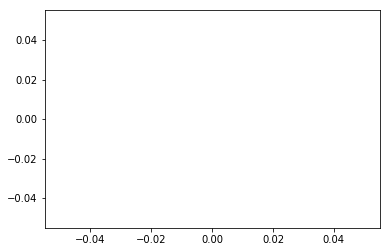

In [39]:
plt.plot(out.data[100:300].numpy())
plt.plot(out1[100:300])
# 当数值大的时候 预测不敢跟上去，两种方法，一种是压制目标值，一种是激励预测值
# 另外应该想一下，跟上去的后果：可能找成更大的误差，
# 为了让预测更加准确，是否应该讲厂的大势给加进去

# 

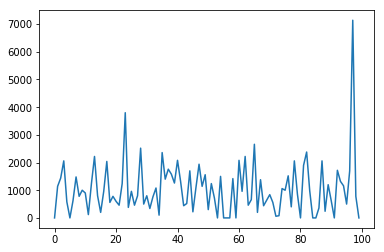

In [96]:
plt.plot(train_y[:100])


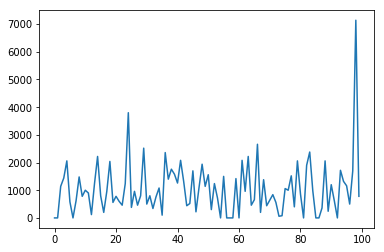

In [94]:
plt.plot(train_x[:100, 1])

In [93]:
train_x.shape

(2589, 5)

In [178]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from sklearn import model_selection

In [198]:
mlp = MLPRegressor()
mlp = mlp.fit(train_x, train_y)
out = mlp.predict(test_x)

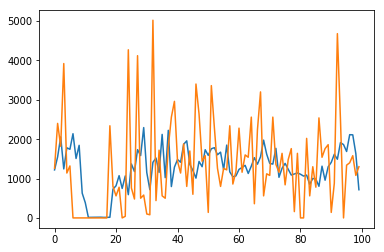

In [199]:
plt.plot(out[:100])
plt.plot(test_y[:100])